In [3]:
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools import jarque_bera
from arch import arch_model

In [5]:
# -----------------------
# 1. Download AMD data (5 years) from Yahoo Finance
# -----------------------
ticker = "AMD"  # Reliance Industries on Yahoo Finance
# Use period='5y' to get last 5 years of daily data
data = yf.download(ticker, period="5y", auto_adjust=True, progress=False)
if data.empty:
    raise RuntimeError("No data downloaded. Check ticker or internet connection.")
print(f"Downloaded {len(data)} rows from {ticker}. Date range: {data.index.min().date()} - {data.index.max().date()}\n")

Downloaded 1255 rows from AMD. Date range: 2020-12-07 - 2025-12-04



In [7]:
data

Price,Close,High,Low,Open,Volume
Ticker,AMD,AMD,AMD,AMD,AMD
Date,,,,,
2020-12-07,94.070000,95.000000,92.970001,94.949997,39815700
2020-12-08,92.919998,94.739998,91.900002,94.050003,33907500
2020-12-09,89.830002,94.699997,89.160004,92.760002,52170400
2020-12-10,91.660004,92.089996,89.029999,89.550003,33804400
2020-12-11,91.650002,92.330002,90.160004,91.540001,28368100
...,...,...,...,...,...
2025-11-28,217.529999,218.300003,214.020004,216.139999,18658000
2025-12-01,219.759995,220.979996,213.500000,213.880005,30768700


In [9]:
# Use the adjusted Close price for returns
prices = data['Close'].copy()  # auto_adjust=True gives adjusted close in 'Close'

In [11]:
prices

Ticker,AMD
Date,
2020-12-07,94.070000
2020-12-08,92.919998
2020-12-09,89.830002
2020-12-10,91.660004
2020-12-11,91.650002
...,...
2025-11-28,217.529999
2025-12-01,219.759995
2025-12-02,215.240005


In [13]:
data.describe()

Price,Close,High,Low,Open,Volume
Ticker,AMD,AMD,AMD,AMD,AMD
count,1255.000000,1255.000000,1255.000000,1255.000000,1.255000e+03
mean,119.317187,121.702773,116.930518,119.391442,6.126455e+07
std,38.687237,39.582353,37.831712,38.824545,2.931995e+07
min,55.939999,58.320000,54.570000,55.520000,1.608570e+07
25%,90.295002,92.049999,88.605000,90.424999,4.046500e+07
50%,110.480003,112.330002,108.500000,110.550003,5.342450e+07
75%,145.750000,148.580002,141.875000,145.814995,7.526155e+07
max,264.329987,267.079987,257.399994,264.190002,2.488596e+08


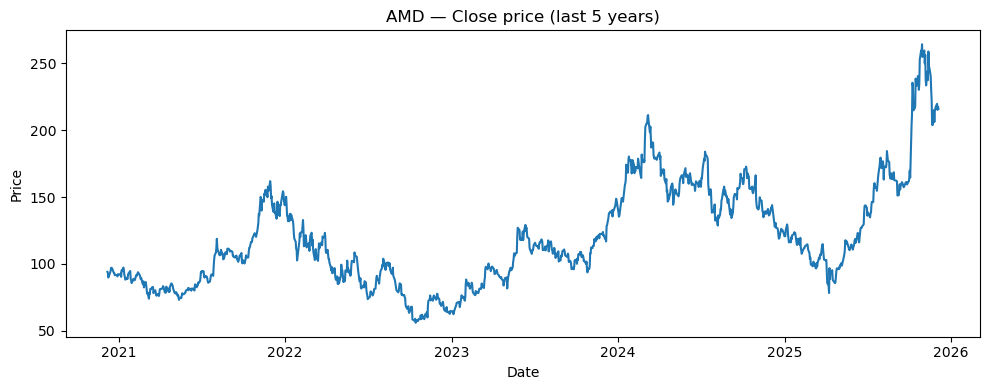

In [15]:
# Optional quick plot of price
plt.figure(figsize=(10,4))
plt.plot(prices.index, prices.values)
plt.title(f"{ticker} — Close price (last 5 years)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

In [17]:
log_ret = np.log(prices).diff().dropna()  # natural log returns
log_ret.name = "log_return"

# Basic stats
print("Return sample size:", len(log_ret))
print(log_ret.describe(), "\n")

Return sample size: 1254
Ticker          AMD
count   1254.000000
mean       0.000663
std        0.032688
min       -0.149299
25%       -0.017581
50%       -0.000117
75%        0.018864
max        0.213663 



In [19]:
## Augmented Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller

def run_adf(series, signif=0.05, name="series"):
    print("="*70)
    print(f"ADF Test for: {name}")
    print("-"*70)

    result = adfuller(series, autolag='AIC')
    adf_stat, pvalue, usedlag, nobs, crit_vals, icbest = result

    # Print raw results
    print(f"ADF Statistic      : {adf_stat:.5f}")
    print(f"p-value            : {pvalue:.5f}")
    print(f"Lags used          : {usedlag}")
    print(f"Number of obs      : {nobs}")
    print("Critical Values:")
    for k, v in crit_vals.items():
        print(f"   {k} : {v:.5f}")

    # Interpretation
    print("\nInterpretation:")
    print(" - H0  (null): The series has a UNIT ROOT → NON-STATIONARY")
    print(" - H1  (alt):  The series has NO unit root → STATIONARY")

    if pvalue < signif:
        print(f" ✔ p-value < {signif}: Reject H0 → The series *is stationary*.")
    else:
        print(f" ✖ p-value >= {signif}: Fail to reject H0 → The series *is NOT stationary*.")

    print("="*70, "\n")
    return result


# Apply it
print(">> ADF on price series (levels)")
adf_price = run_adf(prices.dropna(), name="Price (levels)")

print(">> ADF on log returns")
adf_returns = run_adf(log_ret, name="Log Returns")



>> ADF on price series (levels)
ADF Test for: Price (levels)
----------------------------------------------------------------------
ADF Statistic      : -1.24038
p-value            : 0.65599
Lags used          : 7
Number of obs      : 1247
Critical Values:
   1% : -3.43560
   5% : -2.86386
   10% : -2.56801

Interpretation:
 - H0  (null): The series has a UNIT ROOT → NON-STATIONARY
 - H1  (alt):  The series has NO unit root → STATIONARY
 ✖ p-value >= 0.05: Fail to reject H0 → The series *is NOT stationary*.

>> ADF on log returns
ADF Test for: Log Returns
----------------------------------------------------------------------
ADF Statistic      : -36.18359
p-value            : 0.00000
Lags used          : 0
Number of obs      : 1253
Critical Values:
   1% : -3.43558
   5% : -2.86385
   10% : -2.56800

Interpretation:
 - H0  (null): The series has a UNIT ROOT → NON-STATIONARY
 - H1  (alt):  The series has NO unit root → STATIONARY
 ✔ p-value < 0.05: Reject H0 → The series *is stationary*

In [21]:
# Jarque-Bera Normality test , Skewness and Kurtosis
jb = jarque_bera(log_ret)

jb_stat = jb[0].item() if hasattr(jb[0], "item") else float(jb[0])
jb_pvalue = jb[1].item() if hasattr(jb[1], "item") else float(jb[1])

skew_val = stats.skew(log_ret, bias=False)
skew_val = skew_val.item() if hasattr(skew_val, "item") else float(skew_val)

kurt_val = stats.kurtosis(log_ret, fisher=False, bias=False)
kurt_val = kurt_val.item() if hasattr(kurt_val, "item") else float(kurt_val)

print("\n=== Jarque–Bera Test for Normality ===")
print(f"JB Statistic = {jb_stat:.4f}")
print(f"p-value      = {jb_pvalue:.4f}")

if jb_pvalue < 0.05:
    print("\n❌ p < 0.05 → Reject Normality")
    print("The return series does NOT follow a normal distribution.")
    print("Implication: Normal VaR may underestimate risk.\n")
else:
    print("\n✔ p > 0.05 → Fail to Reject Normality")
    print("The return series appears normally distributed.")
    print("Implication: Normal VaR is statistically acceptable.\n")

print("\n=== Distribution Shape ===")
print(f"Skewness  = {skew_val:.4f}")
if skew_val < 0:
    print("Interpretation: Negative skew → crashes more common than rallies.")
else:
    print("Interpretation: Positive skew → rallies more common than crashes.")

print(f"Kurtosis  = {kurt_val:.4f}")
if kurt_val > 3:
    print("Interpretation: Leptokurtic (fat tails) → more extreme returns.")
elif kurt_val == 3:
    print("Interpretation: Mesokurtic → similar to normal distribution.")
else:
    print("Interpretation: Platykurtic → fewer extreme returns.")



=== Jarque–Bera Test for Normality ===
JB Statistic = 757.6135
p-value      = 0.0000

❌ p < 0.05 → Reject Normality
The return series does NOT follow a normal distribution.
Implication: Normal VaR may underestimate risk.


=== Distribution Shape ===
Skewness  = 0.3390
Interpretation: Positive skew → rallies more common than crashes.
Kurtosis  = 6.7669
Interpretation: Leptokurtic (fat tails) → more extreme returns.


In [23]:
# Ljung Box test for AutoCorrelation
from statsmodels.stats.diagnostic import acorr_ljungbox

def run_ljung_box(series, lags=[10,20], name="series"):
    """
    Runs Ljung-Box Q-test to check autocorrelation in a time series.
    
    Parameters:
    -----------
    series : pandas Series
        The time series (usually residuals or returns).
    lags : list
        List of lags at which to compute the test.
    name : str
        Name of the series.
    """

    print("="*75)
    print(f"Ljung–Box Autocorrelation Test for: {name}")
    print("-"*75)

    lb = acorr_ljungbox(series, lags=lags, return_df=True)

    print(lb)

    print("\nInterpretation:")
    print(" - H0 (null): No autocorrelation up to the given lags.")
    print(" - H1 (alt): Autocorrelation exists → model misses patterns.")

    for lag in lags:
        p = lb.loc[lag, 'lb_pvalue']
        if p < 0.05:
            print(f" ✔ Lag {lag}: p-value={p:.4f} < 0.05 → Reject H0 → Autocorrelation PRESENT.")
        else:
            print(f" ✔ Lag {lag}: p-value={p:.4f} ≥ 0.05 → Fail to reject H0 → No autocorrelation.")

    print("="*75, "\n")
    return lb


# Run it
run_ljung_box(log_ret, lags=[10,20], name="Log Returns")


Ljung–Box Autocorrelation Test for: Log Returns
---------------------------------------------------------------------------
      lb_stat  lb_pvalue
10   9.326558   0.501418
20  20.404389   0.432902

Interpretation:
 - H0 (null): No autocorrelation up to the given lags.
 - H1 (alt): Autocorrelation exists → model misses patterns.
 ✔ Lag 10: p-value=0.5014 ≥ 0.05 → Fail to reject H0 → No autocorrelation.
 ✔ Lag 20: p-value=0.4329 ≥ 0.05 → Fail to reject H0 → No autocorrelation.



,lb_stat,lb_pvalue
10,9.326558,0.501418
20,20.404389,0.432902


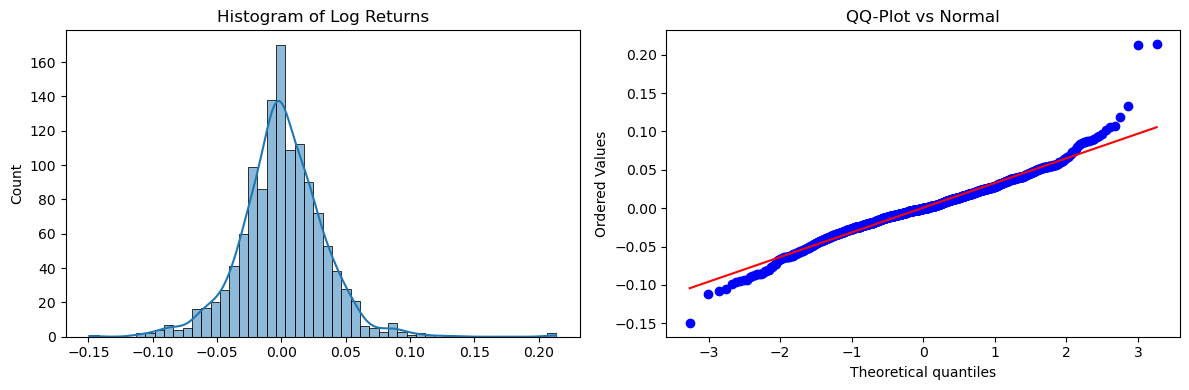

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Ensure log_ret is 1-D
log_ret_1d = np.asarray(log_ret).ravel()

plt.figure(figsize=(12,4))

# Histogram
plt.subplot(1,2,1)
sns.histplot(log_ret_1d, bins=50, kde=True)
plt.title("Histogram of Log Returns")

# QQ Plot
plt.subplot(1,2,2)
stats.probplot(log_ret_1d, dist="norm", plot=plt)
plt.title("QQ-Plot vs Normal")

plt.tight_layout()
plt.show()


In [31]:
from statsmodels.stats.diagnostic import het_arch

# ARCH LM Test
lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(log_ret, nlags=12)

print("\nARCH LM Test (Engle's Test for Volatility Clustering)")
print("-------------------------------------------------------")
print(f"LM Statistic      : {lm_stat:.4f}")
print(f"LM p-value        : {lm_pvalue:.4f}")
print(f"F-Statistic       : {f_stat:.4f}")
print(f"F-test p-value    : {f_pvalue:.4f}")

print("\nWhat this test is for:")
print(" - Checks if the variance of returns changes over time.")
print(" - Financial returns typically show 'volatility clustering':")
print("     periods of high volatility and periods of low volatility.")
print(" - GARCH models are only useful if volatility is time-varying.")
print(" - This test tells us whether GARCH modeling is justified.")

print("\nHypotheses:")
print(" - H0 (null): No ARCH effects → variance is constant over time.")
print(" - H1 (alt):  ARCH effects exist → variance changes over time.")

if lm_pvalue < 0.05:
    print("\nInterpretation:")
    print(" ✔ p-value < 0.05 → Reject H0.")
    print("   This means ARCH effects are present.")
    print("   → Volatility is NOT constant.")
    print("   → There is volatility clustering.")
    print("   → You SHOULD use a GARCH-type model.")
else:
    print("\nInterpretation:")
    print(" ✔ p-value ≥ 0.05 → Fail to reject H0.")
    print("   This means NO significant ARCH effects.")
    print("   → Volatility is roughly constant.")
    print("   → A GARCH model may not be necessary.")

print("-------------------------------------------------------\n")



ARCH LM Test (Engle's Test for Volatility Clustering)
-------------------------------------------------------
LM Statistic      : 22.6618
LM p-value        : 0.0307
F-Statistic       : 1.9034
F-test p-value    : 0.0302

What this test is for:
 - Checks if the variance of returns changes over time.
 - Financial returns typically show 'volatility clustering':
     periods of high volatility and periods of low volatility.
 - GARCH models are only useful if volatility is time-varying.
 - This test tells us whether GARCH modeling is justified.

Hypotheses:
 - H0 (null): No ARCH effects → variance is constant over time.
 - H1 (alt):  ARCH effects exist → variance changes over time.

Interpretation:
 ✔ p-value < 0.05 → Reject H0.
   This means ARCH effects are present.
   → Volatility is NOT constant.
   → There is volatility clustering.
   → You SHOULD use a GARCH-type model.
-------------------------------------------------------



In [35]:
models = {}
dists = ["normal", "t", "skewt"]
for dist in dists:
    print(f"\nFitting GARCH(1,1) with {dist} distribution...")
    am = arch_model(log_ret*100, vol="GARCH", p=1, q=1, dist=dist, mean="Constant")
    res = am.fit(disp="off")
    models[dist] = res
    print(res.summary())


Fitting GARCH(1,1) with normal distribution...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    AMD   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3247.82
Distribution:                  Normal   AIC:                           6503.63
Method:            Maximum Likelihood   BIC:                           6524.17
                                        No. Observations:                 1254
Date:                Fri, Dec 05 2025   Df Residuals:                     1253
Time:                        15:02:32   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu           

In [37]:
import numpy as np
from scipy.stats import norm, t
from arch import arch_model

# Fit GARCH models
models = {}
dists = ["normal", "t", "skewt"]
for dist in dists:
    print(f"\nFitting GARCH(1,1) with {dist} distribution...")
    am = arch_model(log_ret*100, vol="GARCH", p=1, q=1, dist=dist, mean="Constant")
    res = am.fit(disp="off")
    models[dist] = res
    print(res.summary())

print("\n" + "="*80)
print("VALUE-AT-RISK (VaR) AND EXPECTED SHORTFALL (ES) FORECASTS")
print("="*80)

# Calculate VaR and ES for both 5% and 1% levels
alpha_levels = [0.05, 0.01]

for alpha in alpha_levels:
    print(f"\n{'='*80}")
    print(f"Risk Level: {alpha*100}% (Confidence Level: {(1-alpha)*100}%)")
    print(f"{'='*80}")
    
    var_results = {}
    
    for dist, res in models.items():
        # 1-step ahead forecast
        fc = res.forecast(horizon=1, reindex=False)
        mu = fc.mean.iloc[-1, 0]
        sigma = np.sqrt(fc.variance.iloc[-1, 0])
        
        # Standardized residuals
        std_resid = res.std_resid
        
        # ------------------------
        # NORMAL DISTRIBUTION
        # ------------------------
        if dist == "normal":
            q = norm.ppf(alpha)          # q is negative
            var = mu + sigma * q         # VaR is negative
            es  = mu + sigma * (-norm.pdf(q) / alpha)   # ES must be MORE negative
            
        # ------------------------
        # STUDENT-T DISTRIBUTION
        # ------------------------
        elif dist == "t":
            df = res.params["nu"]
            tq = t.ppf(alpha, df)        # negative raw t quantile
            tq_std = tq * np.sqrt((df - 2) / df)
            var = mu + sigma * tq_std
            # Correct t-ES formula (negative expected tail)
            pdf_raw = t.pdf(tq, df)
            es_std = -(pdf_raw / alpha) * ((df + tq**2) / (df - 1)) * np.sqrt((df - 2) / df)
            es = mu + sigma * es_std
            
        # ------------------------
        # SKEW-T (fallback)
        # ------------------------
        else:
            q = np.quantile(std_resid, alpha)
            es_tail = np.mean(std_resid[std_resid <= q])
            var = mu + sigma * q
            es  = mu + sigma * es_tail
        
        # Convert to % properly
        var_pct = var
        es_pct  = es 
        var_results[dist] = (var_pct, es_pct)
        
        print(f"\n{dist.upper()} Distribution:")
        print(f"  • Forecast mean (μ):      {mu:.4f}%")
        print(f"  • Forecast volatility (σ): {sigma:.4f}%")
        if dist == "t":
            print(f"  • Degrees of freedom (ν): {df:.2f}")
        print(f"  • VaR ({alpha*100}%):           {var_pct:.4f}%")
        print(f"  • ES ({alpha*100}%):            {es_pct:.4f}%")
        print(f"\n  Interpretation:")
        print(f"    - With {(1-alpha)*100}% confidence, maximum loss will not exceed {abs(var_pct):.2f}%")
        print(f"    - If loss exceeds VaR threshold, average loss is {abs(es_pct):.2f}%")

# Summary comparison table
print("\n" + "="*80)
print("SUMMARY COMPARISON TABLE")
print("="*80)

import pandas as pd

for alpha in alpha_levels:
    print(f"\nRisk Level: {alpha*100}%")
    print("-" * 80)
    
    summary_data = []
    for dist, res in models.items():
        # Recalculate for this alpha
        fc = res.forecast(horizon=1, reindex=False)
        mu = fc.mean.iloc[-1, 0]
        sigma = np.sqrt(fc.variance.iloc[-1, 0])
        std_resid = res.std_resid
        
        if dist == "normal":
            q = norm.ppf(alpha)
            var = mu + sigma * q
            es = mu + sigma * (-norm.pdf(q) / alpha)
        elif dist == "t":
            df = res.params["nu"]
            tq = t.ppf(alpha, df)
            tq_std = tq * np.sqrt((df - 2) / df)
            var = mu + sigma * tq_std
            pdf_raw = t.pdf(tq, df)
            es_std = -(pdf_raw / alpha) * ((df + tq**2) / (df - 1)) * np.sqrt((df - 2) / df)
            es = mu + sigma * es_std
        else:
            q = np.quantile(std_resid, alpha)
            es_tail = np.mean(std_resid[std_resid <= q])
            var = mu + sigma * q
            es = mu + sigma * es_tail
        
        summary_data.append({
            'Distribution': dist.upper(),
            'Mean (μ)': f"{mu:.4f}%",
            'Volatility (σ)': f"{sigma:.4f}%",
            f'VaR ({alpha*100}%)': f"{var:.4f}%",
            f'ES ({alpha*100}%)': f"{es:.4f}%",
            'VaR (abs)': f"{abs(var):.4f}%",
            'ES (abs)': f"{abs(es):.4f}%"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))

# Additional insights
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
print("\n1. VaR Comparison:")
print("   - Normal distribution typically gives the least conservative (smallest) VaR")
print("   - Student-t accounts for fat tails → more conservative VaR")
print("   - Skewed-t accounts for both fat tails and asymmetry")

print("\n2. ES vs VaR:")
print("   - ES is always MORE negative (larger loss) than VaR")
print("   - ES measures average loss GIVEN that we're in the worst tail")
print("   - ES is a coherent risk measure (VaR is not)")

print("\n3. Model Selection:")
print("   - If residuals show fat tails → prefer Student-t or Skewed-t")
print("   - If residuals show asymmetry → prefer Skewed-t")
print("   - Compare AIC/BIC from model summaries to choose best fit")


Fitting GARCH(1,1) with normal distribution...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    AMD   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3247.82
Distribution:                  Normal   AIC:                           6503.63
Method:            Maximum Likelihood   BIC:                           6524.17
                                        No. Observations:                 1254
Date:                Fri, Dec 05 2025   Df Residuals:                     1253
Time:                        15:02:47   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu           


Diagnostics for normal residuals
ARCH Test: LM=2.7323, p=0.9972
      lb_stat  lb_pvalue
10   7.878151   0.640738
20  17.849270   0.597337


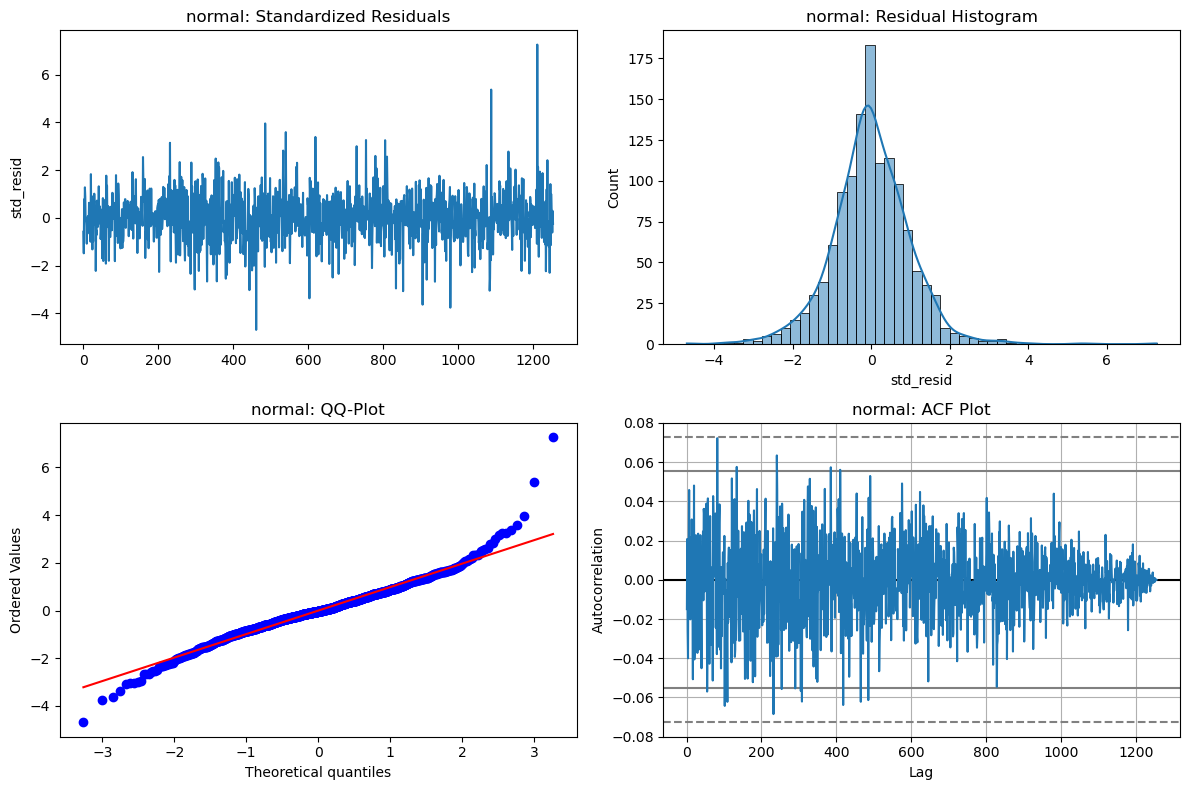


Diagnostics for t residuals
ARCH Test: LM=3.4804, p=0.9911
      lb_stat  lb_pvalue
10   9.052514   0.527127
20  18.656660   0.544234


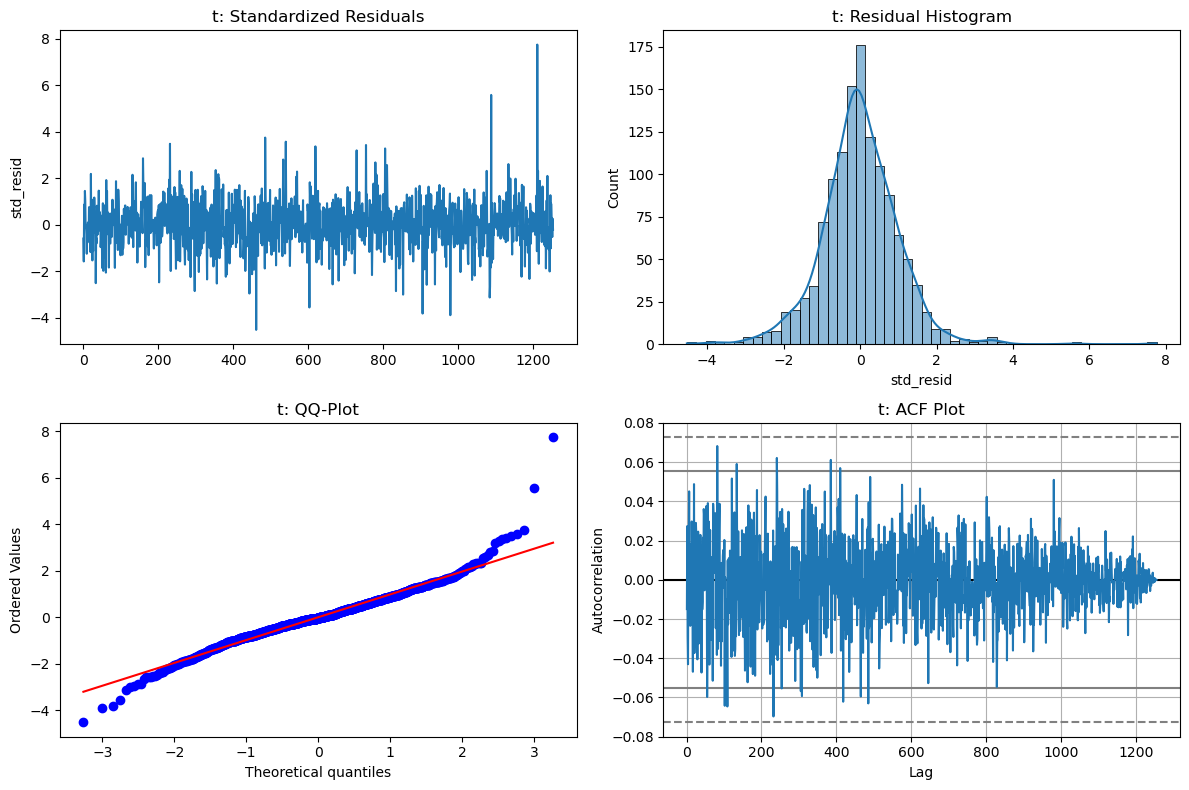


Diagnostics for skewt residuals
ARCH Test: LM=3.4742, p=0.9912
      lb_stat  lb_pvalue
10   9.050485   0.527319
20  18.651805   0.544552


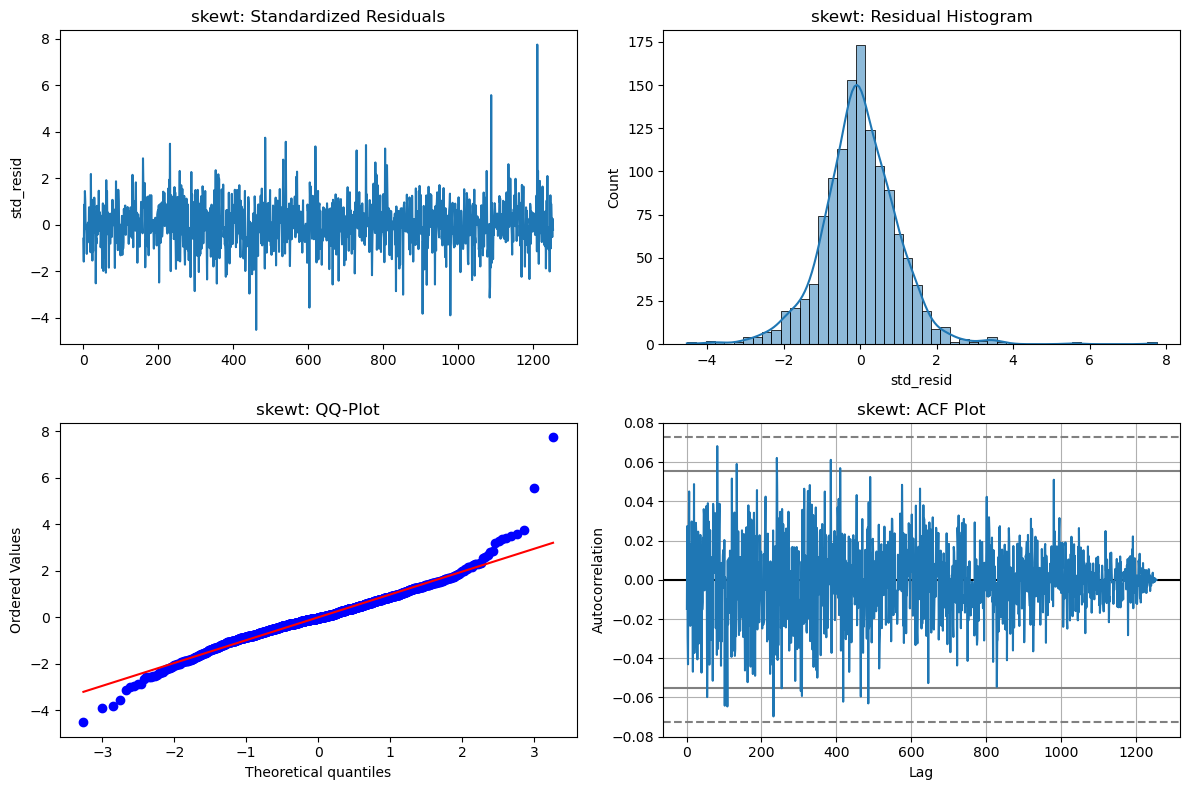

In [39]:
def plot_residual_diagnostics(std_resid, dist_name):

    fig, ax = plt.subplots(2,2,figsize=(12,8))

    sns.lineplot(x=np.arange(len(std_resid)), y=std_resid, ax=ax[0,0])
    ax[0,0].set_title(f"{dist_name}: Standardized Residuals")

    sns.histplot(std_resid, bins=50, kde=True, ax=ax[0,1])
    ax[0,1].set_title(f"{dist_name}: Residual Histogram")

    stats.probplot(std_resid, dist="norm", plot=ax[1,0])
    ax[1,0].set_title(f"{dist_name}: QQ-Plot")

    pd.plotting.autocorrelation_plot(std_resid, ax=ax[1,1])
    ax[1,1].set_title(f"{dist_name}: ACF Plot")

    plt.tight_layout()
    plt.show()


diagnostics = {}
for dist, res in models.items():

    std_resid = pd.Series(res.std_resid)

    print(f"\nDiagnostics for {dist} residuals")
    arch_lm = het_arch(std_resid, nlags=12)
    print(f"ARCH Test: LM={arch_lm[0]:.4f}, p={arch_lm[1]:.4f}")

    lb = acorr_ljungbox(std_resid, lags=[10,20], return_df=True)
    print(lb)

    diagnostics[dist] = {"std_resid": std_resid}

    plot_residual_diagnostics(std_resid, dist)

In [51]:
# Forecasting 1 day VaR (for BOTH 5% and 1%)
import numpy as np
from scipy.stats import norm, t

# Define both levels here at the top
alpha_levels = [0.05, 0.01]          # <-- ADD THIS LINE
var_results = {}                     # will now hold results for both alphas

# Loop over both alpha levels
for alpha in alpha_levels:           # <-- CHANGE THIS LINE (was just alpha = 0.05)
    alpha_pct = int(alpha * 100)
    print(f"\n{'='*60}")
    print(f"          1-DAY FORECAST AT {alpha_pct}% CONFIDENCE LEVEL")
    print(f"{'='*60}")
    
    var_results[alpha] = {}          # nested dict: var_results[0.05]["normal"] = (VaR, ES)
    
    for dist, res in models.items():
        # 1-step ahead forecast
        fc = res.forecast(horizon=1, reindex=False)
        mu = fc.mean.iloc[-1, 0]
        sigma = np.sqrt(fc.variance.iloc[-1, 0])
        std_resid = res.std_resid

        # ------------------------
        # NORMAL DISTRIBUTION
        # ------------------------
        if dist == "normal":
            q = norm.ppf(alpha)
            var = mu + sigma * q
            es = mu + sigma * (-norm.pdf(q) / alpha)

        # ------------------------
        # STUDENT-t DISTRIBUTION
        # ------------------------
        elif dist == "t":
            df = res.params["nu"]
            tq = t.ppf(alpha, df)
            tq_std = tq * np.sqrt((df - 2) / df)
            var = mu + sigma * tq_std
            pdf_raw = t.pdf(tq, df)
            es_std = -(pdf_raw / alpha) * ((df + tq**2) / (df - 1)) * np.sqrt((df - 2) / df)
            es = mu + sigma * es_std

        # ------------------------
        # SKEWED-t (fallback - historical simulation on standardized residuals)
        # ------------------------
        else:
            q = np.quantile(std_resid, alpha)
            es_tail = np.mean(std_resid[std_resid <= q])
            var = mu + sigma * q
            es = mu + sigma * es_tail

        # Store results (as decimal, not %)
        var_results[alpha][dist] = (var, es)

        # Pretty print
        print(f"\n{dist.upper()} Distribution:")
        print(f"   {alpha_pct}% VaR  →  {var:8.4f}%   (1 in {int(1/alpha)} days)")
        print(f"   {alpha_pct}% ES   →  {es:8.4f}%   (expected shortfall)")

    # Nice summary table for this alpha
    print(f"\nSummary at {alpha_pct}% level:")
    print("Distribution    VaR (%)     ES (%)")
    print("-" * 40)
    for dist in models.keys():
        v, e = var_results[alpha][dist]
        print(f"{dist.upper():12}  {v:8.4f}   {e:8.4f}")


          1-DAY FORECAST AT 5% CONFIDENCE LEVEL

NORMAL Distribution:
   5% VaR  →   -5.3535%   (1 in 20 days)
   5% ES   →   -6.7326%   (expected shortfall)

T Distribution:
   5% VaR  →   -5.9262%   (1 in 20 days)
   5% ES   →   -8.5326%   (expected shortfall)

SKEWT Distribution:
   5% VaR  →   -6.1904%   (1 in 20 days)
   5% ES   →   -8.4688%   (expected shortfall)

Summary at 5% level:
Distribution    VaR (%)     ES (%)
----------------------------------------
NORMAL         -5.3535    -6.7326
T              -5.9262    -8.5326
SKEWT          -6.1904    -8.4688

          1-DAY FORECAST AT 1% CONFIDENCE LEVEL

NORMAL Distribution:
   1% VaR  →   -7.6026%   (1 in 100 days)
   1% ES   →   -8.7210%   (expected shortfall)

T Distribution:
   1% VaR  →   -9.9458%   (1 in 100 days)
   1% ES   →  -13.1889%   (expected shortfall)

SKEWT Distribution:
   1% VaR  →   -9.7387%   (1 in 100 days)
   1% ES   →  -12.0693%   (expected shortfall)

Summary at 1% level:
Distribution    VaR (%)     E

Training period: 1004 observations
Testing period: 250 observations
Backtesting VaR at ['5.0%', '1.0%'] levels

Running rolling window backtest...
Processed 50/250 days...
Processed 100/250 days...
Processed 150/250 days...
Processed 200/250 days...
Processed 250/250 days...

BACKTESTING RESULTS

VaR Level: 5.0%

NORMAL Distribution:
  Violations: 14/250 (5.60%)
  Expected:   5.00%
  Difference: +0.60%
  Kupiec LR:  0.1827 (p-value: 0.6691)
  Avg violation size: -7.0260% (loss of 7.0260%)
  Model acceptance: ✓ PASS

T Distribution:
  Violations: 16/250 (6.40%)
  Expected:   5.00%
  Difference: +1.40%
  Kupiec LR:  0.9514 (p-value: 0.3294)
  Avg violation size: -6.9350% (loss of 6.9350%)
  Model acceptance: ✓ PASS

SKEWED-T Distribution:
  Violations: 15/250 (6.00%)
  Expected:   5.00%
  Difference: +1.00%
  Kupiec LR:  0.4961 (p-value: 0.4812)
  Avg violation size: -7.0985% (loss of 7.0985%)
  Model acceptance: ✓ PASS

VaR Level: 1.0%

NORMAL Distribution:
  Violations: 5/250 (2.00%)
 

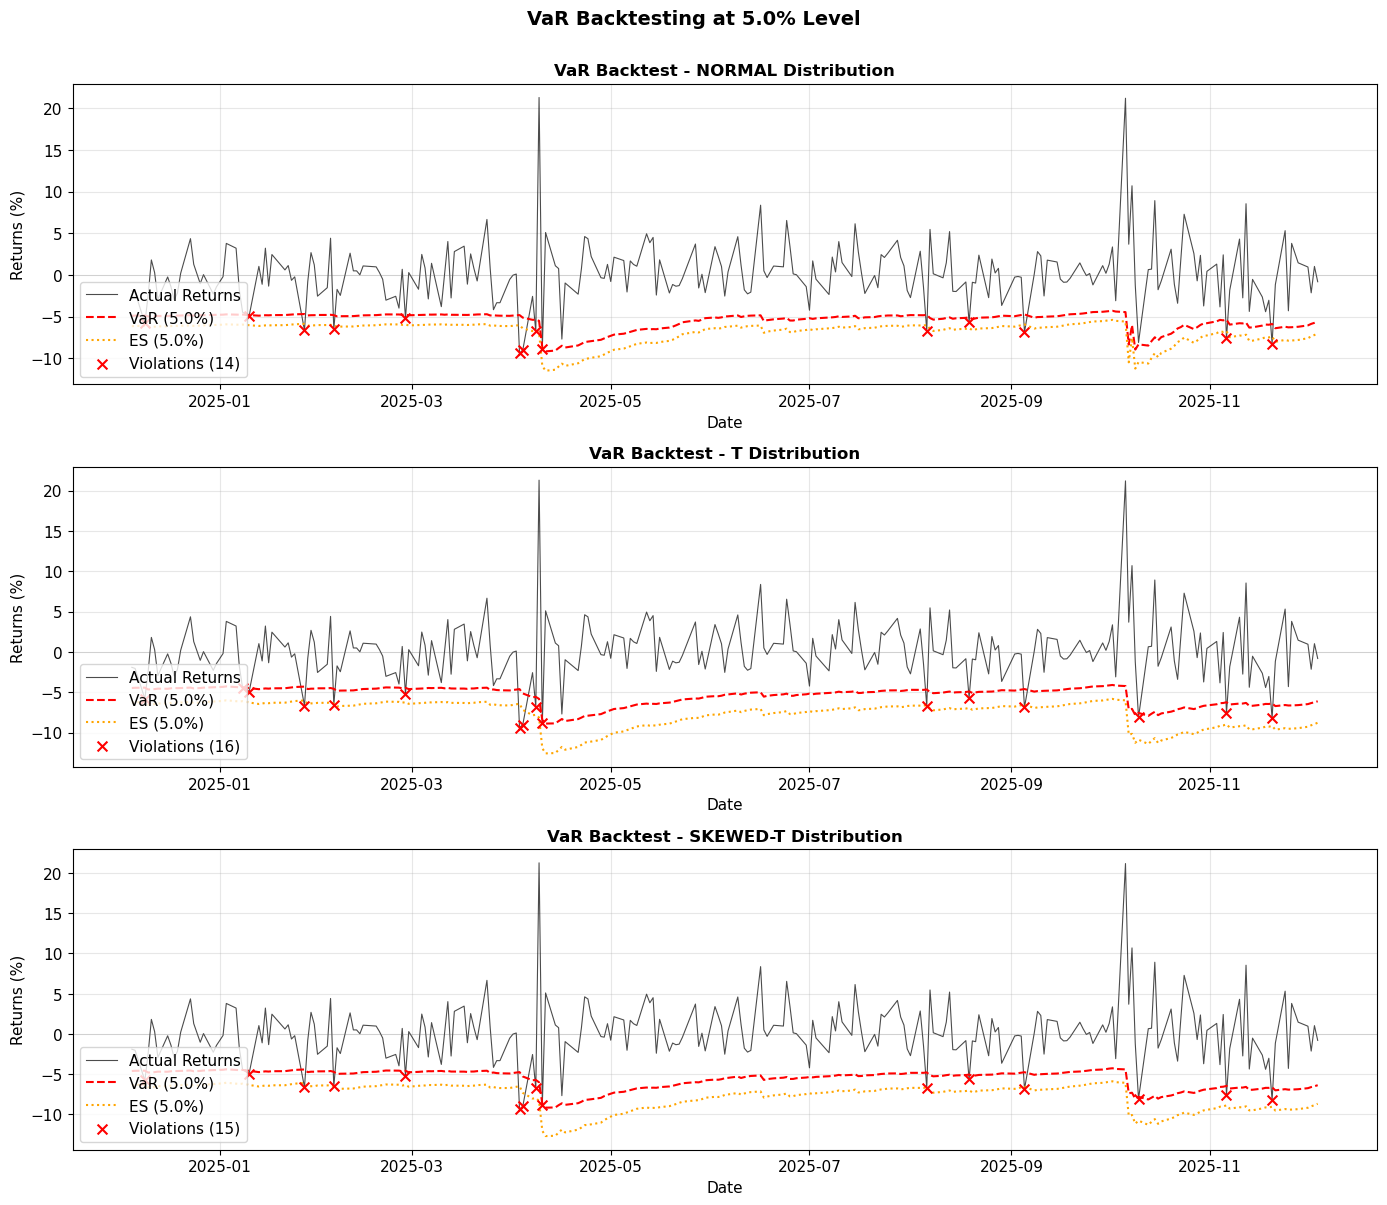

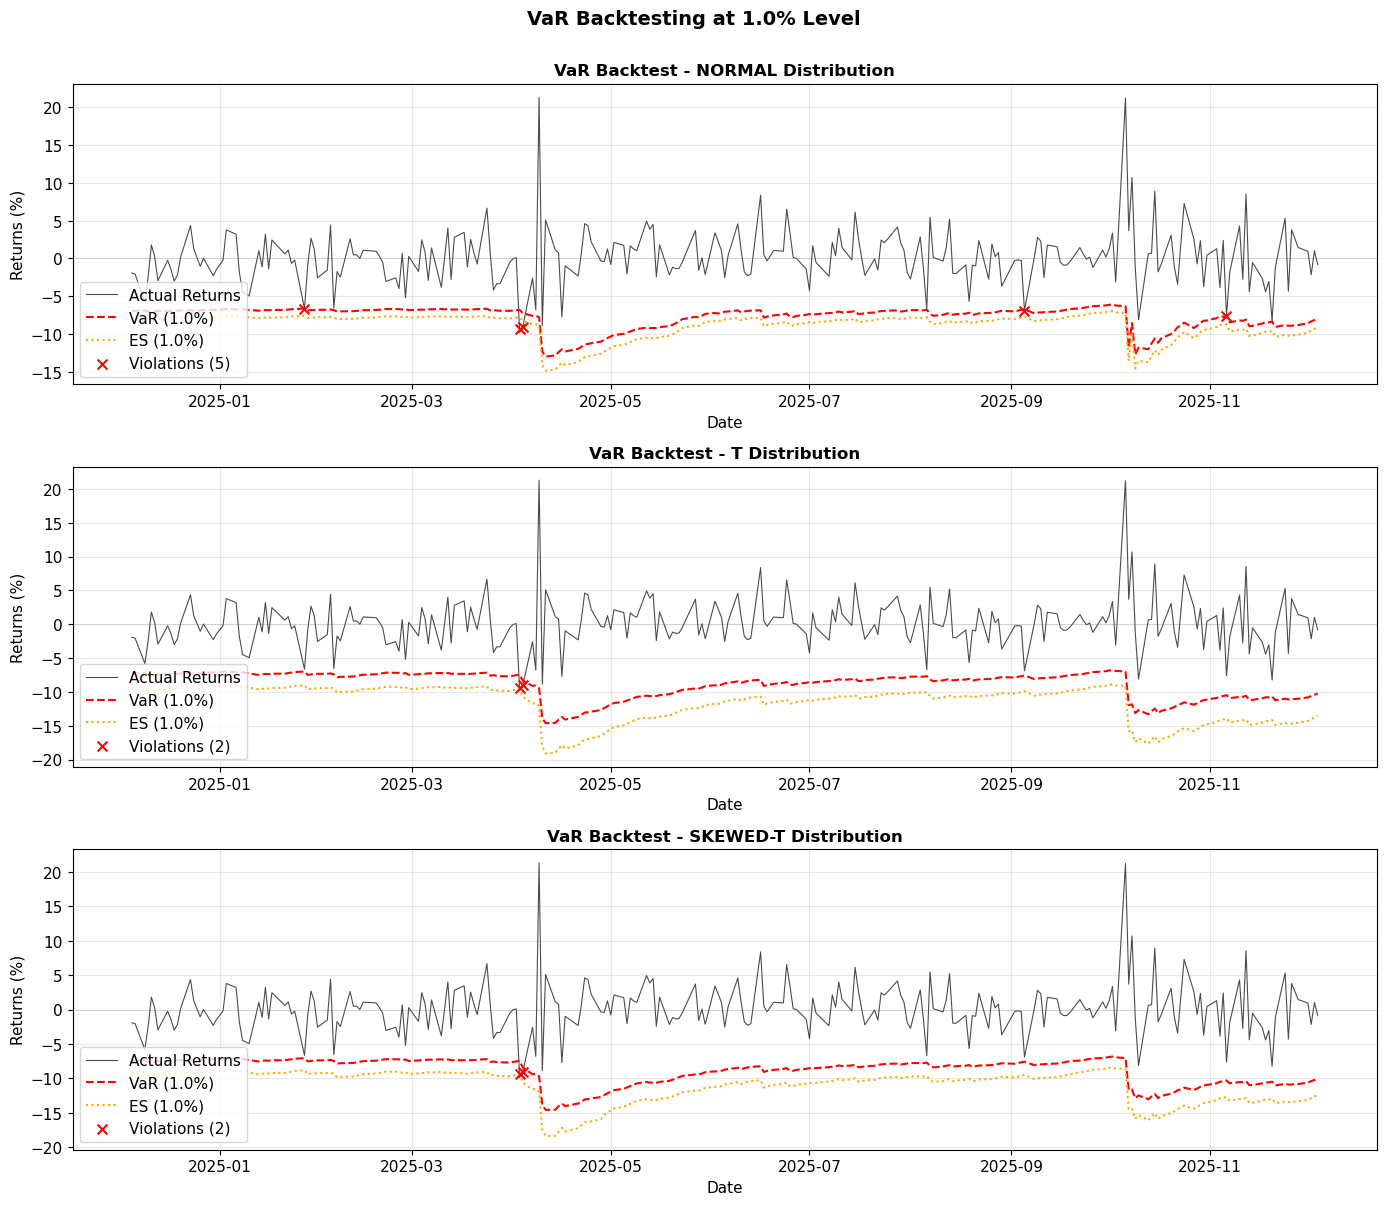


SUMMARY TABLE

VaR Level: 5.0%
Distribution  Violations  Total Days Violation Rate Expected Rate Difference
      NORMAL          14         250          5.60%         5.00%     +0.60%
           T          16         250          6.40%         5.00%     +1.40%
    SKEWED-T          15         250          6.00%         5.00%     +1.00%

VaR Level: 1.0%
Distribution  Violations  Total Days Violation Rate Expected Rate Difference
      NORMAL           5         250          2.00%         1.00%     +1.00%
           T           2         250          0.80%         1.00%     -0.20%
    SKEWED-T           2         250          0.80%         1.00%     -0.20%


In [47]:
# VaR Backtesting with Rolling 250-day Window for (5% and 1% levels) with violations
import numpy as np
import pandas as pd
from scipy.stats import norm, t
from arch import arch_model
import matplotlib.pyplot as plt
import seaborn as sns

# Extract log returns from the fitted models
# Assuming 'models' is a dictionary with keys like "normal", "t", "skewed-t"
# and each contains a fitted GARCH model result object

# Get the returns data from one of the fitted models
sample_model = list(models.values())[0]

# The original returns can be reconstructed from residuals and conditional mean
# For a simple GARCH model without mean model, returns = residuals
log_returns = sample_model.resid

# Configuration
test_period = 250
alpha_levels = [0.05, 0.01]  # Test both 5% and 1% VaR
distributions = ["normal", "t", "skewed-t"]

# Check if we have enough data
if len(log_returns) <= test_period:
    raise ValueError(f"Not enough data. Need more than {test_period} observations, but have {len(log_returns)}")

# Split data
train_returns = log_returns[:-test_period]
test_returns = log_returns[-test_period:]

print(f"Training period: {len(train_returns)} observations")
print(f"Testing period: {len(test_returns)} observations")
print(f"Backtesting VaR at {[f'{a*100}%' for a in alpha_levels]} levels\n")

# Storage for backtest results - now nested by alpha level
backtest_results = {
    alpha: {dist: {'var': [], 'es': [], 'actual': []} for dist in distributions}
    for alpha in alpha_levels
}

# Rolling window backtest
print("Running rolling window backtest...")
for i in range(test_period):
    # Use expanding window (or fixed window by slicing differently)
    # Here we use expanding: train_returns + first i test observations
    window_data = pd.concat([train_returns, test_returns[:i]]) if i > 0 else train_returns
    
    # Actual return for day i in test set
    actual_return = test_returns.iloc[i]
    
    for alpha in alpha_levels:
        for dist in distributions:
            try:
                # Fit GARCH model
                if dist == "normal":
                    model = arch_model(window_data, vol='Garch', p=1, q=1, dist='normal')
                elif dist == "t":
                    model = arch_model(window_data, vol='Garch', p=1, q=1, dist='t')
                else:  # skewed-t
                    model = arch_model(window_data, vol='Garch', p=1, q=1, dist='skewt')
                
                res = model.fit(disp='off', show_warning=False)
                
                # 1-step ahead forecast
                fc = res.forecast(horizon=1, reindex=False)
                mu = fc.mean.iloc[-1, 0]
                sigma = np.sqrt(fc.variance.iloc[-1, 0])
                
                # Calculate VaR and ES
                if dist == "normal":
                    q = norm.ppf(alpha)
                    var = mu + sigma * q
                    es = mu + sigma * (-norm.pdf(q) / alpha)
                    
                elif dist == "t":
                    df = res.params["nu"]
                    tq = t.ppf(alpha, df)
                    tq_std = tq * np.sqrt((df - 2) / df)
                    var = mu + sigma * tq_std
                    pdf_raw = t.pdf(tq, df)
                    es_std = -(pdf_raw / alpha) * ((df + tq**2) / (df - 1)) * np.sqrt((df - 2) / df)
                    es = mu + sigma * es_std
                    
                else:  # skewed-t fallback
                    std_resid = res.std_resid
                    q = np.quantile(std_resid, alpha)
                    es_tail = np.mean(std_resid[std_resid <= q])
                    var = mu + sigma * q
                    es = mu + sigma * es_tail
                
                backtest_results[alpha][dist]['var'].append(var)
                backtest_results[alpha][dist]['es'].append(es)
                backtest_results[alpha][dist]['actual'].append(actual_return)
                
            except Exception as e:
                # Handle fitting errors
                backtest_results[alpha][dist]['var'].append(np.nan)
                backtest_results[alpha][dist]['es'].append(np.nan)
                backtest_results[alpha][dist]['actual'].append(actual_return)
    
    if (i + 1) % 50 == 0:
        print(f"Processed {i + 1}/{test_period} days...")

print("\n" + "="*80)
print("BACKTESTING RESULTS")
print("="*80)

# Analyze backtest results
for alpha in alpha_levels:
    print(f"\n{'='*80}")
    print(f"VaR Level: {alpha*100}%")
    print(f"{'='*80}")
    
    for dist in distributions:
        var_forecast = np.array(backtest_results[alpha][dist]['var'])
        actual = np.array(backtest_results[alpha][dist]['actual'])
        
        # Remove NaN values
        valid_idx = ~np.isnan(var_forecast)
        var_forecast = var_forecast[valid_idx]
        actual = actual[valid_idx]
        
        # VaR violations (when actual return < VaR)
        violations = actual < var_forecast
        n_violations = violations.sum()
        violation_rate = n_violations / len(actual)
        expected_violations = alpha
        
        # Unconditional coverage test (Kupiec test)
        from scipy.stats import chi2
        n = len(actual)
        if n_violations > 0 and n_violations < n:
            lr_uc = -2 * (
                n_violations * np.log(alpha) + (n - n_violations) * np.log(1 - alpha) -
                n_violations * np.log(n_violations / n) - (n - n_violations) * np.log(1 - n_violations / n)
            )
            p_value_uc = 1 - chi2.cdf(lr_uc, 1)
        else:
            lr_uc = np.nan
            p_value_uc = np.nan
        
        # Average VaR violation size (as absolute value for interpretation)
        violation_returns = actual[violations]
        avg_violation = violation_returns.mean() if len(violation_returns) > 0 else 0
        avg_violation_abs = abs(avg_violation)  # Show as positive for easier interpretation
        
        print(f"\n{dist.upper()} Distribution:")
        print(f"  Violations: {n_violations}/{len(actual)} ({violation_rate:.2%})")
        print(f"  Expected:   {expected_violations:.2%}")
        print(f"  Difference: {(violation_rate - expected_violations):+.2%}")
        print(f"  Kupiec LR:  {lr_uc:.4f} (p-value: {p_value_uc:.4f})" if not np.isnan(lr_uc) else "  Kupiec LR:  N/A")
        print(f"  Avg violation size: {avg_violation:.4f}% (loss of {avg_violation_abs:.4f}%)")
        print(f"  Model acceptance: {'✓ PASS' if p_value_uc > 0.05 else '✗ FAIL'}" if not np.isnan(p_value_uc) else "  Model acceptance: N/A")

# Visualization
for alpha in alpha_levels:
    fig, axes = plt.subplots(len(distributions), 1, figsize=(14, 4*len(distributions)))
    if len(distributions) == 1:
        axes = [axes]
    
    fig.suptitle(f'VaR Backtesting at {alpha*100}% Level', fontsize=14, fontweight='bold', y=1.002)

    for idx, dist in enumerate(distributions):
        ax = axes[idx]
        
        var_forecast = np.array(backtest_results[alpha][dist]['var'])
        es_forecast = np.array(backtest_results[alpha][dist]['es'])
        actual = np.array(backtest_results[alpha][dist]['actual'])
        
        dates = test_returns.index
        
        # Plot actual returns
        ax.plot(dates, actual, label='Actual Returns', color='black', alpha=0.7, linewidth=0.8)
        
        # Plot VaR forecast
        ax.plot(dates, var_forecast, label=f'VaR ({alpha*100}%)', color='red', linestyle='--', linewidth=1.5)
        
        # Plot ES forecast
        ax.plot(dates, es_forecast, label=f'ES ({alpha*100}%)', color='orange', linestyle=':', linewidth=1.5)
        
        # Highlight violations
        violations = actual < var_forecast
        ax.scatter(dates[violations], actual[violations], color='red', s=50, zorder=5, 
                   label=f'Violations ({violations.sum()})', marker='x')
        
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)
        ax.set_title(f'VaR Backtest - {dist.upper()} Distribution', fontsize=12, fontweight='bold')
        ax.set_xlabel('Date')
        ax.set_ylabel('Returns (%)')
        ax.legend(loc='lower left')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Summary table
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)

for alpha in alpha_levels:
    print(f"\n{'='*80}")
    print(f"VaR Level: {alpha*100}%")
    print(f"{'='*80}")
    
    summary_data = []
    for dist in distributions:
        var_forecast = np.array(backtest_results[alpha][dist]['var'])
        actual = np.array(backtest_results[alpha][dist]['actual'])
        valid_idx = ~np.isnan(var_forecast)
        var_forecast = var_forecast[valid_idx]
        actual = actual[valid_idx]
        
        violations = (actual < var_forecast).sum()
        violation_rate = violations / len(actual)
        
        summary_data.append({
            'Distribution': dist.upper(),
            'Violations': violations,
            'Total Days': len(actual),
            'Violation Rate': f"{violation_rate:.2%}",
            'Expected Rate': f"{alpha:.2%}",
            'Difference': f"{(violation_rate - alpha):+.2%}"
        })

    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))